In [1]:
# Initial --> Terminal
# Initial, Terminal --> DE

In [1]:
import torch
from torch import nn

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from pyarrow.parquet import ParquetFile, read_table
import numpy as np

from tqdm import tqdm

data_dir = "../../data"

In [2]:
class Control2Pert(nn.Module):

    def __init__(self, in_dim, bottle_dim, pert_dim, out_dim) -> None:
        super().__init__()

        self.enc_layer = nn.Sequential(
            nn.Linear(in_dim, bottle_dim),
            nn.ReLU()
        )
        self.dec_layer = nn.Sequential(
            nn.Linear(bottle_dim+pert_dim, out_dim)
        )
    
    def encode(self, x):
        x = self.enc_layer(x)
        return x
    
    def decode(self, x, pert):
        x = torch.concat([x, pert], dim=1)
        x = self.dec_layer(x)
        return x
    
    def forward(self, x, pert):
        x = self.encode(x)
        x = self.decode(x, pert)
        return x
    
    

In [3]:
# TODO: Donor-Specific
# Dimethyl Sulfoxide
adata_meta = pd.read_csv(f"{data_dir}/adata_obs_meta.csv")
cell_types = list(adata_meta["cell_type"].unique())
mol_types = list(adata_meta["sm_name"].unique())

adata_file = ParquetFile(f"{data_dir}/adata_train.parquet")
# adata_df = adata_file.read_row_groups(list(range(200))).to_pandas()
adata_df = adata_file.read(columns=["obs_id", "gene", "normalized_count"]).to_pandas()
# adata_df = read_table(f"{data_dir}/adata_train.parquet").to_pandas()
gene_names = list(adata_df["gene"].unique())

data_array = np.array(np.zeros((
    len(gene_names), len(mol_types), len(cell_types)
)))

In [5]:
data_array.shape

(21255, 147, 6)

In [6]:
import warnings
warnings.filterwarnings('ignore')

# for k in tqdm(range(0,1588,100)):
#     df = adata_file.read_row_groups(list(range(k,k+100))).to_pandas()
#     df.to_csv(f"{data_dir}/temp/adata_{k}.csv")
# df = adata_file.read_row_groups(list(range(1500,1588))).to_pandas()
# df.to_csv(f"{data_dir}/temp/adata_1500.csv")

In [9]:
data_array = np.array(np.zeros((
    2, len(gene_names), len(mol_types), len(cell_types)
)))

for i, cell_type in enumerate(cell_types):
    print ("cell", i, "which is", cell_type)
    for j, mol in enumerate(tqdm(mol_types)):
        wanted_ids = adata_meta[adata_meta["cell_type"]==cell_type][
            adata_meta["sm_name"]==mol]["obs_id"]
        wanted_df = pd.DataFrame()
        # for k in range(0,1588,300):
        #     if k>1499:
        #         df = adata_file.read_row_groups(list(range(k,1588))).to_pandas()
        #     else: 
        #         df = adata_file.read_row_groups(list(range(k,k+100))).to_pandas()
            # df = pd.read_csv(f"{data_dir}/temp/adata_{k}.csv")
            # df = df[df["obs_id"].isin(wanted_ids)]
            # wanted_df = pd.concat([wanted_df, df], axis=0)
            # del df
        wanted_df = adata_df[adata_df["obs_id"].isin(wanted_ids)]
        wanted_pivot = wanted_df.pivot_table("normalized_count", "obs_id", "gene")
        wanted_means = pd.Series([-1]*len(gene_names), index=gene_names)
        wanted_means[list(wanted_pivot.columns)] = wanted_pivot.mean()
        wanted_stds = pd.Series([-1]*len(gene_names), index=gene_names)
        wanted_stds[list(wanted_pivot.columns)] = wanted_pivot.std()
        data_array[0, :, j, i] = wanted_means.to_numpy()
        data_array[1, :, j, i] = wanted_stds.to_numpy()
        # print("done:", "cell", i, "mol", j, end="\r")

cell 0 which is T cells CD4+


100%|██████████| 147/147 [46:39<00:00, 19.05s/it] 


cell 1 which is T regulatory cells


100%|██████████| 147/147 [36:14<00:00, 14.79s/it]


cell 2 which is T cells CD8+


100%|██████████| 147/147 [36:32<00:00, 14.91s/it]


cell 3 which is NK cells


100%|██████████| 147/147 [43:11<00:00, 17.63s/it]


cell 4 which is B cells


100%|██████████| 147/147 [12:31<00:00,  5.11s/it]


cell 5 which is Myeloid cells


100%|██████████| 147/147 [14:02<00:00,  5.73s/it]


In [10]:
with open(f"{data_dir}/adata.npy", "wb") as f:
    np.save(f, data_array)

In [11]:
import pickle as pkl
with open(f"{data_dir}/adata.npy.meta.pickle", "wb") as f:
    save_dict = {
        "gene_names": gene_names,
        "mols": mol_types,
        "cell_types": cell_types,
    }
    pkl.dump(save_dict, f)

In [14]:
import pickle as pkl
with open(f"{data_dir}/adata.npy", "rb") as f:
    data = np.load(f)
with open(f"{data_dir}/adata.npy.meta.pickle", "rb") as f:
    meta = pkl.load(f)

In [21]:
(data[:, :, :, 0:4]==-1).sum()/data[:, :, :, 0:4].size

0.3770376558056768

In [57]:
import matplotlib.pyplot as plt

(array([  2.,   0.,   0.,   0.,   0.,   2.,   5., 132.,   3.,   3.]),
 array([ 6219. ,  7640.3,  9061.6, 10482.9, 11904.2, 13325.5, 14746.8,
        16168.1, 17589.4, 19010.7, 20432. ]),
 <BarContainer object of 10 artists>)

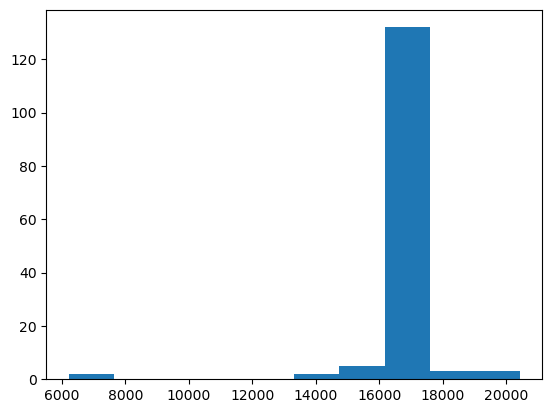

In [58]:
plt.hist(((data[0, :, :, 0].squeeze()>0).sum(axis=0)))

In [ ]:
from tqdm import tqdm

import torch

### FUNCTIONS ###
def loss_mrrmse(y_pred, y_true):

    loss = (y_true - y_pred) ** 2
    loss = loss.mean(dim=1)
    loss = torch.sqrt(loss)
    loss = loss.mean(dim=0)

    return loss

def train_one_epoch(model, train_loader, loss_fn, 
                    optimizer, device):

    # Send model to device
    model.to(device)

    # Set model to train mode
    model.train()

    # Iterate over batches and take optimization steps
    losses = []
    for batch in train_loader:

        x_batch, y_batch = batch
        y_batch = y_batch.to(device)
        y_pred = model(*x_batch, device) # TODO: Send to device the x in model?

        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss)
     
    return losses

def infer_model(model, data_loader, loss_fn, 
                metrics: dict, device, calculate_loss=False):

    data_len = len(data_loader)
    
    # Send model to device
    model.to(device)

    # Set model to evaluation mode
    model.eval()

    # Create Output Dict
    metric_values = dict()
    for metric_name in metrics:
        metric_values[metric_name] = 0

    with torch.no_grad():
        
        losses = []
        for batch in data_loader:

            x_batch, y_batch = batch
            y_batch = y_batch.to(device)
            print(x_batch)
            y_pred = model(*x_batch, device)

            if calculate_loss:
                loss = loss_fn(y_pred, y_batch)
                losses.append(loss)

            for metric_name in metrics:
                metric_value = metrics[metric_name](y_pred, y_batch)
                metric_values[metric_name] += (metric_value / data_len)

    if calculate_loss:
        return losses, metric_values
    else:
        return metric_values
        
def train_many_epochs(model, train_loader, val_loader, epochs,
                      loss_fn, optimizer, scheduler=None, 
                      metrics=[], writer=None, device="cpu"):
    
    for epoch in tqdm(range(epochs)):

        # Train model for one epoch and calculate metrics for the 
        # resulting model...
        train_b_losses = train_one_epoch(model, train_loader, loss_fn, 
                                         optimizer, device)
        train_b_metrics = infer_model(model, train_loader, loss_fn, 
                                      metrics, device)
        val_b_losses, val_b_metrics = infer_model(model, val_loader, loss_fn, 
                                    metrics, device, calculate_loss=True)
        
        epoch_train_loss = sum(train_b_losses) / len(train_b_losses)
        epoch_val_loss = sum(val_b_losses) / len(val_b_losses)
        if writer:
            writer.add_scalar("Training Loss", epoch_train_loss, global_step=epoch)
            writer.add_scalar("Validation Loss", epoch_val_loss, global_step=epoch)
        if scheduler:
            scheduler.step(epoch_train_loss)

In [20]:
data.shape

(2, 21255, 147, 6)

In [69]:
meta["mols"].index("Dimethyl Sulfoxide")

15

In [83]:
import deepchem as dc

ModuleNotFoundError: No module named 'tensorflow'

In [86]:
slice(1, 4, 1).start

1